<a href="https://colab.research.google.com/github/prachi735/EVA5/blob/main/session6/EVA5_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

# Transformations

In [3]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                      # transforms.RandomAffine((-5.0,5.0),fillcolor=1),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [4]:
train = datasets.MNIST('./data', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./data', train=True, download=True,transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloaders: Test/Train dataset

In [5]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics & Sample Data


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: 

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor(33.3184)
 - std: tensor(78.5675)
 - var: tensor(6172.8506)
torch.Size([128, 1, 28, 28])
torch.Size([128])


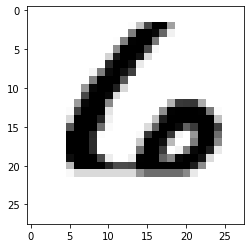

In [6]:
# converting array into numpy from tensor
train_data = train.train_data
#train_data = train.transform(train.train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.Tensor.float(train_data).mean())
print(' - std:', torch.Tensor.float(train_data).std())
print(' - var:', torch.Tensor.float(train_data).var())

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[52].numpy().squeeze(), cmap='gray_r')


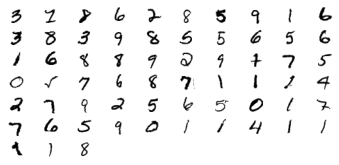

In [7]:
figure = plt.figure()
num_of_images = 63
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Data properties

In [8]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


# Basic Model

In [9]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [12]:
gbn_splits = 2
class Net(nn.Module):
    def __init__(self, is_gbn = True):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 26 output_size = 24 receptive_field = 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, gbn_splits) if is_gbn else nn.BatchNorm2d(16)
        ) # input_size = 12 output_size = 10 receptive_field = 5

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 12 output_size = 10 receptive_field = 5


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24 output_size = 12 receptive_field = 

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, gbn_splits) if is_gbn else nn.BatchNorm2d(16)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16, gbn_splits) if is_gbn else nn.BatchNorm2d(16)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10, gbn_splits) if is_gbn else nn.BatchNorm2d(10)
        ) # input_size = 5 output_size = 3 receptive_field = 13

        # OUTPUT BLOCK
        self.convblock10 = nn.Sequential(
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)   
        
    

# Model Params

In [14]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
    GhostBatchNorm-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
    GhostBatchNorm-9           [-1, 16, 22, 22]              32
           Conv2d-10           [-1, 10, 22, 22]             160
             ReLU-11           [-1, 10, 22, 22]               0
   GhostBatchNorm-12           [-1, 10, 22, 22]              20
        MaxPool2d-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

In [15]:
print(model)

Net(
  (convblock1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock3): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock4): Sequential(
    (0): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): GhostBatchNorm(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock5): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3

#Training & Testing

In [106]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, l1_loss_flag, lamda_l1 = 0.0001):
  
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_loss_flag:
      l1 = 0
      for p in model.parameters():
        l1 = l1+p.abs().sum()
      loss += lamda_l1 * l1
      
    train_losses = loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc = 100*correct/processed

    return {"train_losses":train_losses,"train_acc":train_acc}

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses = test_loss

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 
        100. * correct / len(test_loader.dataset)))
    
    test_acc = 100. * correct / len(test_loader.dataset)

    return {"test_losses":test_losses,"test_acc":test_acc}

# Train & Test model

In [228]:
def run_model(optimiser, l1_loss_flag = False):
  model =  Net().to(device)
  train_loss=[]
  train_acc=[]
  test_loss=[]
  test_acc=[]
  EPOCHS = 1
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1)
      train_info = train(model, device, train_loader, optimizer,epoch, l1_loss_flag, lamda_l1=0.0001)
      test_info = test(model, device, test_loader)
      train_loss.append(train_info['train_losses'])
      train_acc.append(train_info['train_acc'])
      test_loss.append(test_info['test_losses'])
      test_acc.append(test_info['test_acc'])
  return {'train_loss':train_loss,  'train_acc':train_acc,  'test_loss':test_loss,  'test_acc':test_acc}

In [229]:
check_cond = ["L1+BN", "L2+BN", "L1+L2+BN","GBN","L1+L2+GBN"]
l1_loss_flag = False
GBN_loss_flag = False
data = {}
for chck in check_cond:
  if chck in [ "L2+BN", "L1+L2+BN","L1+L2+GBN"]:
    optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0, weight_decay=0,nesterov=False)
  else:
    optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0.9)
  
  l1_loss_flag = "L1" in chck   
  GBN_loss_flag = "GBN" in chck

  print("\nModel Running for:",chck)
  print("L1_Flag",l1_loss_flag)
  print("GBN_Flag",GBN_loss_flag)
  data[chck] = run_model(optimizer,l1_loss_flag)
  


  0%|          | 0/469 [00:00<?, ?it/s]


Model Running for: L1+BN
L1_Flag True
GBN_Flag False
EPOCH: 1


Loss=2.9495089054107666 Batch_id=0 Accuracy=14.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3027, Accuracy: 5949/60000 (9.91%)

EPOCH: 2


Loss=3.041602611541748 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3029, Accuracy: 5949/60000 (9.91%)

EPOCH: 3


Loss=3.039137125015259 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3032, Accuracy: 5949/60000 (9.91%)

EPOCH: 4


Loss=2.8064234256744385 Batch_id=0 Accuracy=13.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3036, Accuracy: 5949/60000 (9.91%)

EPOCH: 5


Loss=2.9151997566223145 Batch_id=0 Accuracy=14.84:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3040, Accuracy: 5949/60000 (9.91%)

EPOCH: 6


Loss=2.9126760959625244 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3046, Accuracy: 5949/60000 (9.91%)

EPOCH: 7


Loss=2.8050754070281982 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3052, Accuracy: 5949/60000 (9.91%)

EPOCH: 8


Loss=2.9523515701293945 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3061, Accuracy: 5949/60000 (9.91%)

EPOCH: 9


Loss=3.0217318534851074 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3070, Accuracy: 5949/60000 (9.91%)

EPOCH: 10


Loss=2.9884121417999268 Batch_id=0 Accuracy=6.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3080, Accuracy: 5949/60000 (9.91%)

EPOCH: 11


Loss=3.1233224868774414 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3092, Accuracy: 5949/60000 (9.91%)

EPOCH: 12


Loss=2.996875762939453 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3105, Accuracy: 5949/60000 (9.91%)

EPOCH: 13


Loss=3.029820442199707 Batch_id=0 Accuracy=4.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3121, Accuracy: 5949/60000 (9.91%)

EPOCH: 14


Loss=2.9867987632751465 Batch_id=0 Accuracy=12.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3136, Accuracy: 5949/60000 (9.91%)

EPOCH: 15


Loss=3.0733392238616943 Batch_id=0 Accuracy=6.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3154, Accuracy: 5949/60000 (9.91%)


Model Running for: L2+BN
L1_Flag False
GBN_Flag False
EPOCH: 1


Loss=2.653045892715454 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 6742/60000 (11.24%)

EPOCH: 2


Loss=2.526864767074585 Batch_id=0 Accuracy=12.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 6742/60000 (11.24%)

EPOCH: 3


Loss=2.6698930263519287 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 6742/60000 (11.24%)

EPOCH: 4


Loss=2.754964590072632 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3022, Accuracy: 6742/60000 (11.24%)

EPOCH: 5


Loss=2.7369465827941895 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 6742/60000 (11.24%)

EPOCH: 6


Loss=2.6376984119415283 Batch_id=0 Accuracy=6.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 6742/60000 (11.24%)

EPOCH: 7


Loss=2.6531460285186768 Batch_id=0 Accuracy=4.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 6742/60000 (11.24%)

EPOCH: 8


Loss=2.5837419033050537 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 6742/60000 (11.24%)

EPOCH: 9


Loss=2.8296408653259277 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3027, Accuracy: 6742/60000 (11.24%)

EPOCH: 10


Loss=2.6680285930633545 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3028, Accuracy: 6742/60000 (11.24%)

EPOCH: 11


Loss=2.576110601425171 Batch_id=0 Accuracy=14.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3030, Accuracy: 6742/60000 (11.24%)

EPOCH: 12


Loss=2.7070860862731934 Batch_id=0 Accuracy=6.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3032, Accuracy: 6742/60000 (11.24%)

EPOCH: 13


Loss=2.7062582969665527 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3036, Accuracy: 6742/60000 (11.24%)

EPOCH: 14


Loss=2.634840726852417 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3041, Accuracy: 6735/60000 (11.22%)

EPOCH: 15


Loss=2.6353328227996826 Batch_id=0 Accuracy=14.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3048, Accuracy: 6697/60000 (11.16%)


Model Running for: L1+L2+BN
L1_Flag True
GBN_Flag False
EPOCH: 1


Loss=3.026792049407959 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3029, Accuracy: 6131/60000 (10.22%)

EPOCH: 2


Loss=2.845472574234009 Batch_id=0 Accuracy=12.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3032, Accuracy: 6132/60000 (10.22%)

EPOCH: 3


Loss=2.730884075164795 Batch_id=0 Accuracy=10.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3036, Accuracy: 6131/60000 (10.22%)

EPOCH: 4


Loss=2.818582534790039 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3041, Accuracy: 5805/60000 (9.68%)

EPOCH: 5


Loss=2.8823471069335938 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3047, Accuracy: 5779/60000 (9.63%)

EPOCH: 6


Loss=2.852501392364502 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3052, Accuracy: 5851/60000 (9.75%)

EPOCH: 7


Loss=2.956150770187378 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3059, Accuracy: 5851/60000 (9.75%)

EPOCH: 8


Loss=2.8496999740600586 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3065, Accuracy: 5851/60000 (9.75%)

EPOCH: 9


Loss=2.6559340953826904 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3072, Accuracy: 5851/60000 (9.75%)

EPOCH: 10


Loss=2.865797996520996 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3078, Accuracy: 5851/60000 (9.75%)

EPOCH: 11


Loss=2.9817352294921875 Batch_id=0 Accuracy=5.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3085, Accuracy: 5851/60000 (9.75%)

EPOCH: 12


Loss=2.818007469177246 Batch_id=0 Accuracy=14.84:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3091, Accuracy: 5851/60000 (9.75%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3096, Accuracy: 5852/60000 (9.75%)

EPOCH: 14


Loss=2.781890392303467 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3099, Accuracy: 5919/60000 (9.87%)

EPOCH: 15


Loss=2.816823720932007 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3103, Accuracy: 6389/60000 (10.65%)


Model Running for: GBN
L1_Flag False
GBN_Flag True
EPOCH: 1


Loss=2.7306013107299805 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 6265/60000 (10.44%)

EPOCH: 2


Loss=2.6998157501220703 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 6265/60000 (10.44%)

EPOCH: 3


Loss=2.656900405883789 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 6265/60000 (10.44%)

EPOCH: 4


Loss=2.715785026550293 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3027, Accuracy: 6265/60000 (10.44%)

EPOCH: 5


Loss=2.6486713886260986 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3029, Accuracy: 6265/60000 (10.44%)

EPOCH: 6


Loss=2.540541887283325 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3031, Accuracy: 6265/60000 (10.44%)

EPOCH: 7


Loss=2.7761693000793457 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3034, Accuracy: 6265/60000 (10.44%)

EPOCH: 8


Loss=2.7688910961151123 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3038, Accuracy: 6265/60000 (10.44%)

EPOCH: 9


Loss=2.6598446369171143 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3042, Accuracy: 6265/60000 (10.44%)

EPOCH: 10


Loss=2.7157399654388428 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3046, Accuracy: 6269/60000 (10.45%)

EPOCH: 11


Loss=2.9061150550842285 Batch_id=0 Accuracy=3.91:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3051, Accuracy: 6462/60000 (10.77%)

EPOCH: 12


Loss=2.6853694915771484 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3056, Accuracy: 7309/60000 (12.18%)

EPOCH: 13


Loss=2.708083152770996 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3063, Accuracy: 7974/60000 (13.29%)

EPOCH: 14


Loss=2.858743190765381 Batch_id=0 Accuracy=4.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3072, Accuracy: 6854/60000 (11.42%)

EPOCH: 15


Loss=2.743457794189453 Batch_id=0 Accuracy=10.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3084, Accuracy: 5725/60000 (9.54%)


Model Running for: L1+L2+GBN
L1_Flag True
GBN_Flag True
EPOCH: 1


Loss=2.848266839981079 Batch_id=0 Accuracy=11.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3028, Accuracy: 6267/60000 (10.45%)

EPOCH: 2


Loss=2.853228807449341 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3032, Accuracy: 6265/60000 (10.44%)

EPOCH: 3


Loss=2.9494881629943848 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3036, Accuracy: 6265/60000 (10.44%)

EPOCH: 4


Loss=2.8668859004974365 Batch_id=0 Accuracy=2.34:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3041, Accuracy: 6265/60000 (10.44%)

EPOCH: 5


Loss=2.9204204082489014 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3048, Accuracy: 6265/60000 (10.44%)

EPOCH: 6


Loss=2.7938501834869385 Batch_id=0 Accuracy=12.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3055, Accuracy: 6265/60000 (10.44%)

EPOCH: 7


Loss=2.9249649047851562 Batch_id=0 Accuracy=4.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3064, Accuracy: 6265/60000 (10.44%)

EPOCH: 8


Loss=2.835472822189331 Batch_id=0 Accuracy=16.41:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3074, Accuracy: 6265/60000 (10.44%)

EPOCH: 9


Loss=2.8571484088897705 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3085, Accuracy: 6265/60000 (10.44%)

EPOCH: 10


Loss=2.9887232780456543 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3098, Accuracy: 6265/60000 (10.44%)

EPOCH: 11


Loss=2.915025234222412 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3111, Accuracy: 6265/60000 (10.44%)

EPOCH: 12


Loss=2.9108633995056152 Batch_id=0 Accuracy=15.62:   0%|          | 0/469 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

# Ploting model result

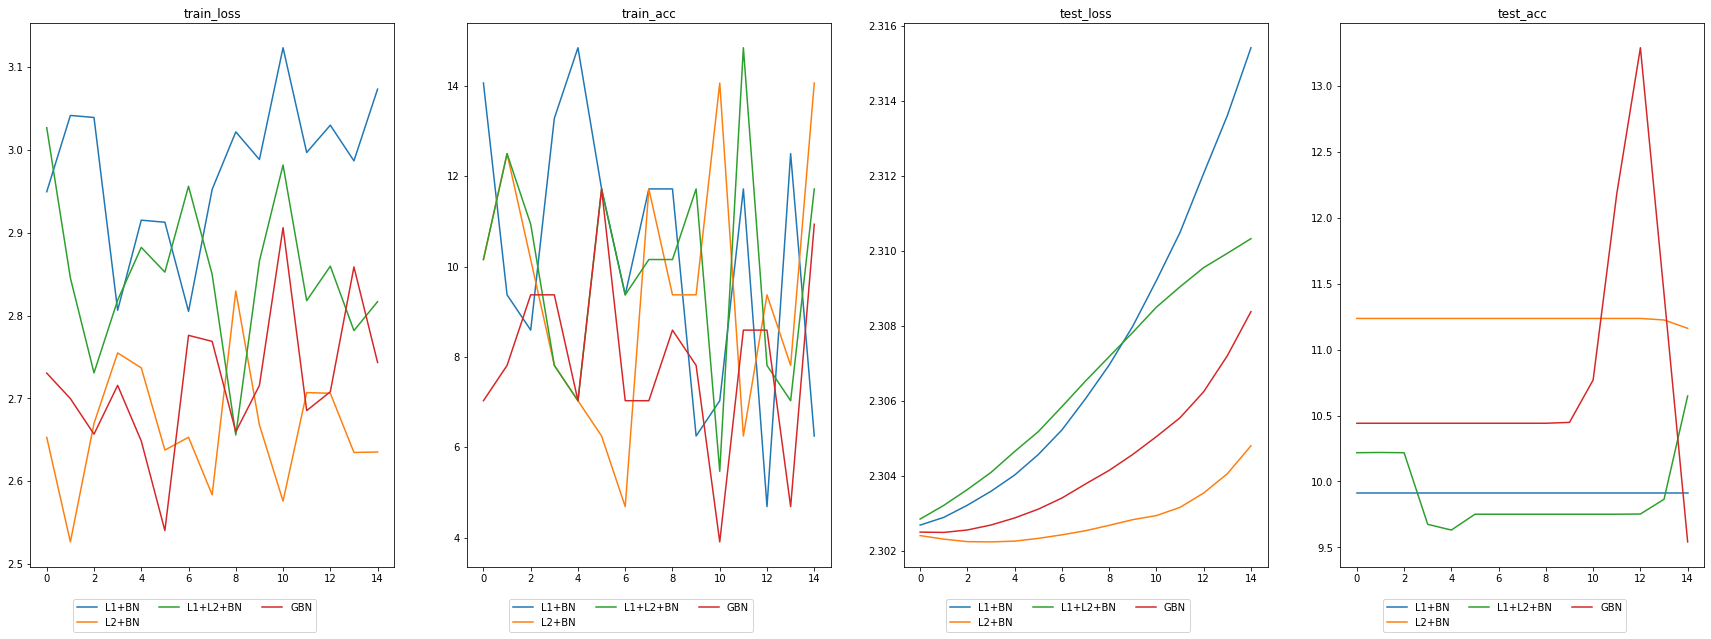

In [230]:
fig, axs = plt.subplots(1,4,figsize=(30,10))
axs_pos = {'train_loss':(0),
'train_acc':(1),
'test_loss':(2),
'test_acc':(3)}
for d in data:
  for i in data[d]:
    ax = axs[axs_pos[i]]
    ax.plot(data[d][i],label=d)
    ax.legend(bbox_to_anchor=(.8, -.05),ncol=3)#,#bbox_transform=ax.transAxes)
    ax.set_title(i)